In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 08:03:51] [setup] RAM Tracking...
[codecarbon INFO @ 08:03:51] [setup] GPU Tracking...
[codecarbon INFO @ 08:03:51] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:03:51] [setup] CPU Tracking...
[codecarbon WARNING @ 08:03:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 08:03:54] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 08:03:54] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 08:03:54] >>> Tracker's metadata:
[codecarbon INFO @ 08:03:54]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 08:03:54]   Python version: 3.11.3
[codecarbon INFO @ 08:03:54]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 08:03:54]   Available RAM : 256.000 GB
[codecarbon INFO @ 08:03:54]   CPU count: 24
[codecarbon INFO @ 08:03:54]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# For reproducibility. Same as when the model was trained
HASH_NAME = "18gqn5gdnlbv"

In [5]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [6]:
import pandas as pd
project_name = "MongoDB"
path_name  = "/fp/homes01/u01/ec-krimhau/thesis_code/priority_model_deberta/github_models/high_vs_med_low/hp_vs_low_med_top50repos/csv"
file_name = f"{path_name}/clean_{project_name}_balanced.csv"

In [7]:
df = pd.read_csv(file_name)
df

,text_clean,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [8]:
df = df.rename(columns={'text_clean': 'text'})
df = df.dropna()  # This will drop any rows with missing values.
df = df.reset_index(drop=True)
df

,text,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [9]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [10]:
class TD_Model(nn.Module):
    def __init__(self, model_name):
        super(TD_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

<h2> Testing Inference </h2>


In [11]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [12]:
test_df = df

In [13]:
test_df

,text,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [14]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [15]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = TD_Model(CONFIG['model_name'])

In [16]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [17]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [18]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'../../01_training/{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 114/114 [01:22<00:00,  1.38it/s]


Fold 1


100%|██████████| 114/114 [01:21<00:00,  1.39it/s]


Fold 2


100%|██████████| 114/114 [01:22<00:00,  1.38it/s]


In [19]:
deberta_predictions


[array([[0.47757462, 0.52242535],
        [0.1337095 , 0.8662905 ],
        [0.5980007 , 0.40199926],
        ...,
        [0.4308157 , 0.5691843 ],
        [0.34167638, 0.6583236 ],
        [0.42102328, 0.5789767 ]], dtype=float32),
 array([[0.2739637 , 0.72603637],
        [0.00375022, 0.99624974],
        [0.2008968 , 0.7991032 ],
        ...,
        [0.25488776, 0.74511224],
        [0.05124216, 0.9487579 ],
        [0.12801927, 0.8719807 ]], dtype=float32),
 array([[0.4650937 , 0.53490627],
        [0.08602696, 0.91397303],
        [0.26448312, 0.73551685],
        ...,
        [0.25649133, 0.74350864],
        [0.42603016, 0.57396984],
        [0.54656374, 0.4534363 ]], dtype=float32)]

In [20]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.405544  , 0.594456  ],
       [0.07449556, 0.92550445],
       [0.3544602 , 0.64553976],
       ...,
       [0.31406495, 0.685935  ],
       [0.2729829 , 0.7270171 ],
       [0.3652021 , 0.6347979 ]], dtype=float32)

In [21]:
len(predictions)

1816

In [22]:
predictions

array([[0.405544  , 0.594456  ],
       [0.07449556, 0.92550445],
       [0.3544602 , 0.64553976],
       ...,
       [0.31406495, 0.685935  ],
       [0.2729829 , 0.7270171 ],
       [0.3652021 , 0.6347979 ]], dtype=float32)

In [23]:
test_df["prediction_0"] = predictions[:, 0] 

In [24]:
test_df["prediction_1"] = predictions[:, 1] 

In [25]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [26]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
0,info ccdashboardauthauthproperties no jwt secr...,0,0.405544,0.594456,1,1,1
1,first logged failure here note that this commi...,1,0.074496,0.925504,1,1,1
2,i perform following tutorial for my knowledgei...,1,0.354460,0.645540,0,1,1
3,description yes it would be a new component of...,1,0.413836,0.586164,1,1,0
4,createuser docs are wrong the name of the user...,1,0.553690,0.446310,1,0,0
...,...,...,...,...,...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0,0.477111,0.522889,0,1,0
1812,we must make sure that there are no more users...,0,0.327823,0.672177,1,1,1
1813,paneltitleissue status as of june issue summar...,1,0.314065,0.685935,1,1,1
1814,the topology coordinator is the repository for...,0,0.272983,0.727017,1,1,1


In [27]:
len(test_df)

1816

In [28]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [29]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [30]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [31]:
test_df["pred"] = test_df["pred"].astype(int)

In [32]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
0,info ccdashboardauthauthproperties no jwt secr...,0,0.405544,0.594456,1,1,1,prediction_1,1
1,first logged failure here note that this commi...,1,0.074496,0.925504,1,1,1,prediction_1,1
2,i perform following tutorial for my knowledgei...,1,0.354460,0.645540,0,1,1,prediction_1,1
3,description yes it would be a new component of...,1,0.413836,0.586164,1,1,0,prediction_1,1
4,createuser docs are wrong the name of the user...,1,0.553690,0.446310,1,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0,0.477111,0.522889,0,1,0,prediction_1,1
1812,we must make sure that there are no more users...,0,0.327823,0.672177,1,1,1,prediction_1,1
1813,paneltitleissue status as of june issue summar...,1,0.314065,0.685935,1,1,1,prediction_1,1
1814,the topology coordinator is the repository for...,0,0.272983,0.727017,1,1,1,prediction_1,1


In [33]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[448 460]
 [371 537]]


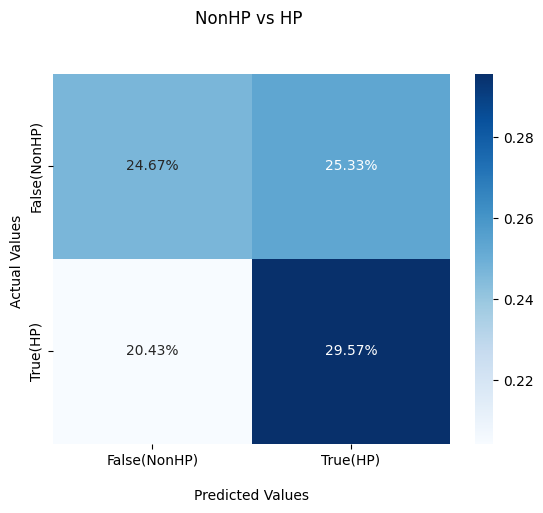

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [35]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.55      0.49      0.52       908
           1       0.54      0.59      0.56       908

    accuracy                           0.54      1816
   macro avg       0.54      0.54      0.54      1816
weighted avg       0.54      0.54      0.54      1816



In [36]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.08521208563302526


In [37]:
test_df[["text","label","pred"]].to_csv(f"csv/{project_name}_Test_inference.csv")

In [38]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
0,info ccdashboardauthauthproperties no jwt secr...,0,0.405544,0.594456,1,1,1,prediction_1,1
1,first logged failure here note that this commi...,1,0.074496,0.925504,1,1,1,prediction_1,1
2,i perform following tutorial for my knowledgei...,1,0.354460,0.645540,0,1,1,prediction_1,1
3,description yes it would be a new component of...,1,0.413836,0.586164,1,1,0,prediction_1,1
4,createuser docs are wrong the name of the user...,1,0.553690,0.446310,1,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0,0.477111,0.522889,0,1,0,prediction_1,1
1812,we must make sure that there are no more users...,0,0.327823,0.672177,1,1,1,prediction_1,1
1813,paneltitleissue status as of june issue summar...,1,0.314065,0.685935,1,1,1,prediction_1,1
1814,the topology coordinator is the repository for...,0,0.272983,0.727017,1,1,1,prediction_1,1


In [39]:
tracker.stop()

0.0006852104355756709